# Single label Classifier - AF Detection

Using the dataset provided by the 2020 Physionet Challenge we've developed an Atrial Fibrilation Detector trained to identify AF diagnosed patiences from a dataset containing patiances with different pathologies like: PAC, RBBB, I-AVB, PVC, LBBB, STD, STE and healthy individuals.

Although data from 12-lead ECG was provided, for this first analysis we've only used the lead 2 data and we've processed the signals in order to create a dataframe consisting of features we believe will help us classify.


In [1]:
import sys
import os

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy

from xverse.transformer import WOE

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from IPython.display import display

from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

import mlflow
import mlflow.sklearn

%matplotlib inline
import plotly.express as px
import seaborn as sns

## Now we can choose which lead data to load

### Lead 2 data seems to give better results:

In [2]:
ls datasets

phys-raw-lead2-HRV-corrected  phys-raw-lead2-HRV-eda


In [3]:
lead = 'HRV-lead2'
df_raw = pd.read_feather('datasets/phys-raw-lead2-HRV-corrected')
df_raw.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_pNN50', 'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'mean_P_Peaks', 'age',
       'label'],
      dtype='object')

In [4]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000
mean,0.177548,0.104988,0.028937,0.133488,0.079104,0.091173,0.243566,0.114294,0.026901
std,0.382160,0.306560,0.167642,0.340127,0.269921,0.287877,0.429265,0.318191,0.161807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df_raw = df_raw.loc[df_raw['age'] >= 0]

## Removing Redundant Features

By calculating a Dendrogram we look for features that may be providing the same information so we can remove them and end up with a cleaner model.

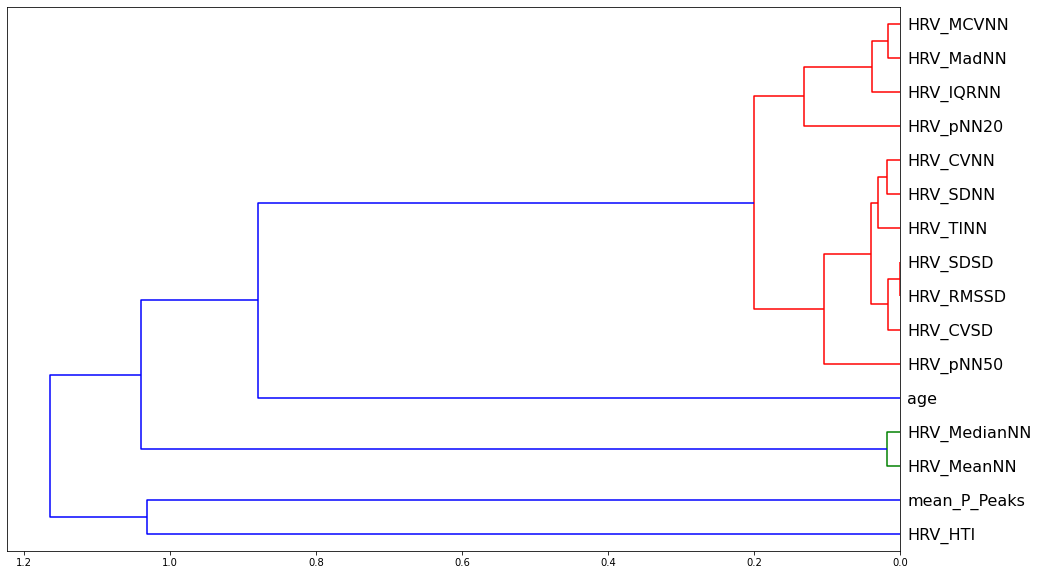

In [6]:
corr = np.round(scipy.stats.spearmanr(df_raw.drop('label',axis=1)).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_raw.drop('label',axis=1).columns, orientation='left', leaf_font_size=16)
plt.show()

Given that the variance can be obtained from the std, and viceversa it's no surprise they seem to provide the same information. Let's try and remove them.

In [7]:
to_drop = ['HRV_SDSD']
df_raw = df_raw.drop(to_drop, axis=1)

<AxesSubplot:>

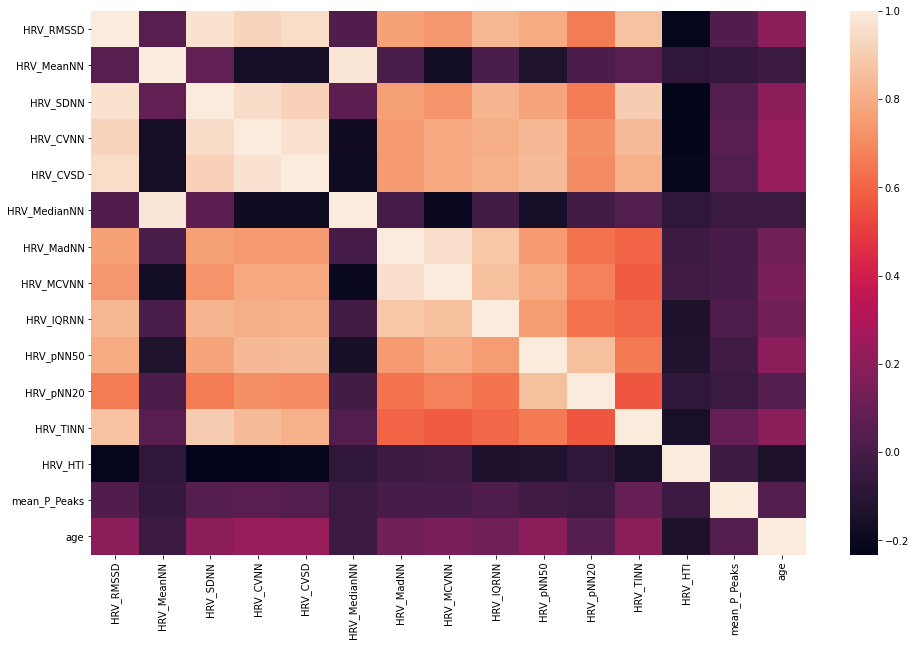

In [8]:
plt.figure(figsize=(16,10))
sns.heatmap(df_raw.corr())

### Renaming everything else as "Non-AF" in both sets

In [9]:
df_raw.loc[df_raw.label != 'AF', 'label'] = 'Non-AF'

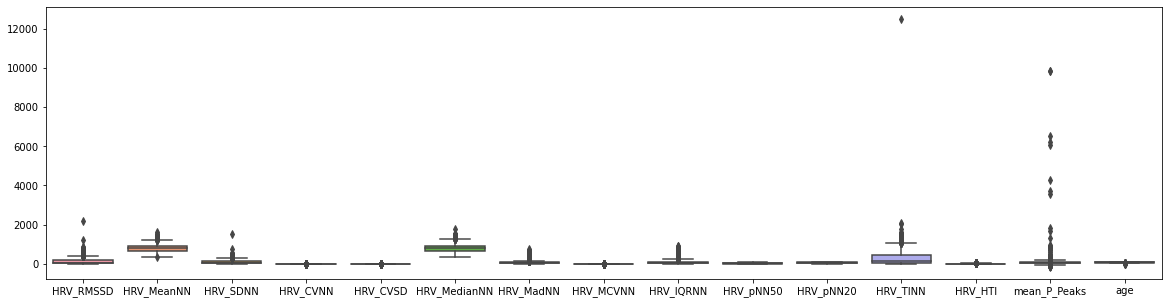

In [10]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df_raw)
plt.show()

Seems to be an outlier so we'll remove that one from our dataset

In [11]:
#df_raw = df_raw.drop(df_raw.loc[df_raw.HRV_TINN > 12000,'HRV_TINN'].index)
#df_raw = df_raw.drop(df_raw.loc[df_raw.mean_P_Peaks > 1000,'mean_P_Peaks'].index)

In [12]:
df = df_raw.copy()
cols = df_raw.columns
cols = cols.drop('label')
for col in cols:
    df = df[df[col] < df[col].quantile(.99)]
    
df_raw = df.copy()

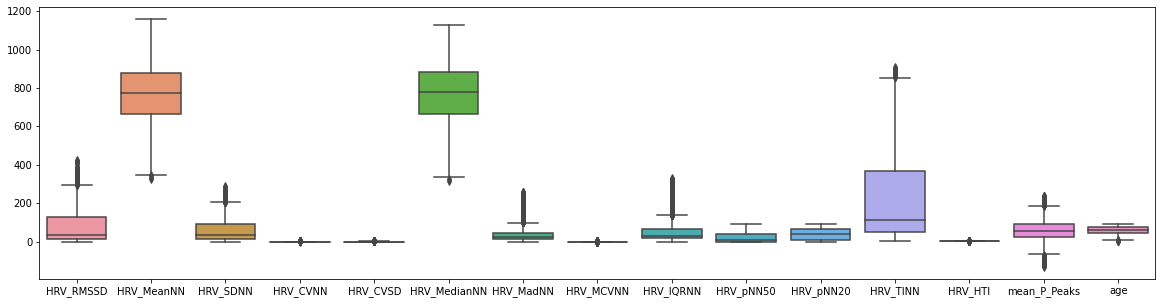

In [13]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df_raw)
plt.show()

In [14]:
#plt.figure(figsize=(30,10))
#%time sns.pairplot(data=df_raw.sample(frac=0.1, random_state=42), hue='label', palette='Set2', height=1.5)
#plt.show()

In [78]:
df_raw = pd.read_feather('datasets/phys-raw-lead2-HRV-eda')
df_raw.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_CVNN', 'HRV_CVSD',
       'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'mean_P_Peaks', 'age', 'label'],
      dtype='object')

In [79]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,Non-AF
count,5852.000000,5852.000000
mean,0.156015,0.843985
std,0.362901,0.362901
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


## Split between Train and Validation Datasets

### Training Set (80%) - Validation (20%)

In [80]:
y = df_raw['label']
X = df_raw.drop('label', axis=1)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

## We check for missing values

In [81]:
df_raw.isnull().sum()

HRV_RMSSD       0
HRV_MeanNN      0
HRV_SDNN        0
HRV_CVNN        0
HRV_CVSD        0
HRV_MedianNN    0
HRV_MadNN       0
HRV_MCVNN       0
HRV_IQRNN       0
HRV_pNN50       0
HRV_pNN20       0
HRV_TINN        0
HRV_HTI         0
mean_P_Peaks    0
age             0
label           0
dtype: int64

## Evaluation Metrics

This are the evaluation metrics we are actually interested in.

In [82]:
res = pd.DataFrame({'model':[], 'f1':[]})

### We process our datasets and train our model

In [83]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(X_train, y_train)

f1_score(y_eval, lr.predict(X_eval), pos_label='AF')

CPU times: user 33.2 ms, sys: 28.2 ms, total: 61.4 ms
Wall time: 700 ms


0.9198966408268733

In [ ]:
res = res.append({'model':'Logistic Regression',
                  'f1': f1_score(y_eval, lr.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [ ]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(X_train, y_train)

f1_score(y_eval, rf.predict(X_eval), pos_label='AF')

In [ ]:
res = res.append({'model':'Random Forest',
                  'f1': f1_score(y_eval, rf.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [ ]:
svc = SVC()

%time svc.fit(X_train, y_train)

f1_score(y_eval, svc.predict(X_eval), pos_label='AF')

In [ ]:
res = res.append({'model':'SVC',
                  'f1': f1_score(y_eval, svc.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [ ]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(X_train, y_train)

f1_score(y_eval, knn.predict(X_eval), pos_label='AF')

In [ ]:
res = res.append({'model':'KNN',
                  'f1': f1_score(y_eval, knn.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [ ]:
res.sort_values('f1', ascending=False)

## Let's try a Standard Scaler

In [ ]:
scal = StandardScaler()
xtrain_scal = scal.fit_transform(X_train)
xeval_scal = scal.transform(X_eval)

In [ ]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(xtrain_scal, y_train)

f1_score(y_eval, lr.predict(xeval_scal), pos_label='AF')

In [ ]:
res = res.append({'model':'Logistic Regression Scal',
                  'f1': f1_score(y_eval, lr.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [ ]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(xtrain_scal, y_train)

f1_score(y_eval, rf.predict(xeval_scal), pos_label='AF')

In [ ]:
res = res.append({'model':'Random Forest Scal',
                  'f1': f1_score(y_eval, rf.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [ ]:
svc = SVC()

%time svc.fit(xtrain_scal, y_train)

f1_score(y_eval, svc.predict(xeval_scal), pos_label='AF')

In [ ]:
res = res.append({'model':'SVC Scal',
                  'f1': f1_score(y_eval, svc.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [ ]:
knn = KNeighborsClassifier()

%time knn.fit(xtrain_scal, y_train)

f1_score(y_eval, knn.predict(xeval_scal), pos_label='AF')

In [ ]:
res = res.append({'model':'KNN Scal',
                  'f1': f1_score(y_eval, knn.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [ ]:
res.sort_values('f1', ascending=False)

### Let's check and see if there's a polynomical relation between features

In [ ]:
X_train.columns

In [ ]:
xpol_train = X_train.drop('age', axis=1)
xpol_eval = X_eval.drop('age', axis=1)

poly = PolynomialFeatures(2, include_bias=False)

xtrain_poly = poly.fit_transform(xpol_train)
xeval_poly = poly.transform(xpol_eval)

xtrain_poly = np.c_[xtrain_poly, X_train.age]
xeval_poly = np.c_[xeval_poly, X_eval.age]

scal = StandardScaler()
xtrain_poly = scal.fit_transform(xtrain_poly)
xeval_poly = scal.transform(xeval_poly)

In [ ]:
xtrain_poly.shape

In [ ]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(xtrain_poly, y_train)

f1_score(y_eval, lr.predict(xeval_poly), pos_label='AF')

In [ ]:
res = res.append({'model':'Logistic Regression Poly',
                  'f1': f1_score(y_eval, lr.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [ ]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(xtrain_poly, y_train)

f1_score(y_eval, rf.predict(xeval_poly), pos_label='AF')

In [ ]:
res = res.append({'model':'Random Forest Poly',
                  'f1': f1_score(y_eval, rf.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [ ]:
svc = SVC()

%time svc.fit(xtrain_poly, y_train)

f1_score(y_eval, svc.predict(xeval_poly), pos_label='AF')

In [ ]:
res = res.append({'model':'SVC Poly',
                  'f1': f1_score(y_eval, svc.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [ ]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(xtrain_poly, y_train)

f1_score(y_eval, knn.predict(xeval_poly), pos_label='AF')

In [ ]:
res = res.append({'model':'KNN Poly',
                  'f1': f1_score(y_eval, knn.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [ ]:
res.sort_values('f1', ascending=False)

## We take a look at Principal Component Analysis

In [ ]:
n_comps = X_train.shape[1]

pca = PCA(n_components = n_comps)

train_pca = pca.fit_transform(xtrain_scal)

eval_pca = pca.transform(xeval_scal)

In [ ]:
xpca = pd.DataFrame(train_pca)

sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))
plt.scatter(xpca.loc[(y_train == 'AF').ravel(),0],xpca.loc[(y_train == 'AF').ravel(),1], alpha = 0.3, label = 'AF')
plt.scatter(xpca.loc[(y_train == 'Non-AF').ravel(),0],xpca.loc[(y_train == 'Non-AF').ravel(),1], alpha = 0.3, label = 'Non-AF')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

In [ ]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(train_pca, y_train)

f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')

In [ ]:
res = res.append({'model':'Logistic Regression PCA',
                  'f1': f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [ ]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(train_pca, y_train)

f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')

In [ ]:
res = res.append({'model':'Random Forest PCA',
                  'f1': f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [ ]:
svc = SVC()

%time svc.fit(train_pca, y_train)

f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')

In [ ]:
res = res.append({'model':'SVC PCA',
                  'f1': f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [ ]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(train_pca, y_train)

f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')

In [ ]:
res = res.append({'model':'KNN PCA',
                  'f1': f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [ ]:
res.sort_values('f1', ascending=False)

In [ ]:
ypred = rf.predict(eval_pca)

cm = confusion_matrix(y_eval, ypred)

df_cm = pd.DataFrame(cm, index = ['AF', 'Control'], columns = ['AF', 'Control'])
plt.figure(figsize = (16,10))
sns.heatmap(df_cm, annot=True)
plt.title('Classification Confusion matrix')
plt.show()

## Confidence based on Tree Variance

We take a look at the standard deviation among trees to see how confident we are about each classification. 

In [ ]:
preds = np.stack([t.predict(eval_pca) for t in rf.estimators_])

### We use the statistical Bootstrap Method

The bootstrap method is a popular non-parametric method, which does not require any distributional assumptions. Efron and Tibshirani provide a detailed review of the bootstrap method. The following is an algorithmic approach of obtaining a (1−α)100% percentile bootstrap conﬁdence interval for the population mean.

In [ ]:
from sklearn.utils import resample

n_iterations = 300
n_size = int(len(preds) * 0.60)

Lowers = []
Uppers = []

for i in range(len(preds[0])):
    
    means = []
    
    for _ in range(n_iterations):
        rs = resample(preds[:, i], n_samples=n_size, replace=True)
        means.append(np.mean(rs))
    
    alpha = 0.99
    p = ((1.0 - alpha) / 2.0) * 100
    lower = max(0.0, np.percentile(means, p))
    Lowers.append(lower)
    
    p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    upper = min(1.0, np.percentile(means, p))
    Uppers.append(upper)

In [ ]:
y_eval = pd.Categorical(y_eval)
y = y_eval.codes

In [ ]:
X = pd.DataFrame(eval_pca)

X['actuals'] = y
X['preds'] = np.mean(preds, axis=0)
X['std'] = (np.std(preds, axis=0))
X['upper'] = Uppers - np.mean(preds, axis=0)
X['lower'] = np.mean(preds, axis=0) - Lowers
X['var'] = (np.var(preds, axis=0))
flds = ['actuals', 'preds', 'std', 'var', 'upper', 'lower']
X.loc[:5,flds]

### Predictions and intervals for the first 50 samples of the evaluation set

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Control',
    y=X['preds'][:50],
    error_y=dict(
            type='data',
            symmetric=False,
            array=X['upper'][:50],
            arrayminus=X['lower'][:50])))

fig.update_layout(shapes=[
    dict(type= 'line', yref='y', y0= 0.5, y1= 0.5, xref= 'x', x0= -1, x1= 50)])
fig.show()

### We analyze those the model seems to be sure about it's classification

Let's keep those where the prediction minus the lower limit error is above 0.9 and those where the prediction plus the upper limit error is below 0.1. 

In [ ]:
aux = X.loc[(X['preds'] - X['lower'] >= 0.7) | (X['preds'] + X['upper'] <= 0.3), flds]
a = np.array(aux.preds > 0.5)

aux['prediction'] = 0

aux.loc[aux.preds > 0.5, 'prediction'] = 1

f1_score(aux.actuals, aux.prediction, pos_label=0), len(aux), len(X), len(aux)/len(X)

#### It seems we can predict 87% of this set with a 98% chance of being correct.